In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from opgp import *

In [3]:
OPERATORS = {
    "identity": identity,
    "gradient": jax.grad,
    "hessian": jax.hessian,
    # "jvp": make_jvp_operator(jnp.array([1.0, 2.0])),
    # "jvpjvp": compose(
    #     make_jvp_operator(jnp.array([1.0, 2.0])), 
    #     make_jvp_operator(jnp.array([2.0, 3.0]))
    # ),
    # "hvp": compose(make_jvp_operator(jnp.array([1.0, 2.0])), jax.grad)
}
OPERATORS

{'identity': <function opgp.identity(f)>,
 'gradient': <function jax._src.api.grad(fun: Callable, argnums: Union[int, Sequence[int]] = 0, has_aux: bool = False, holomorphic: bool = False, allow_int: bool = False, reduce_axes: Sequence[Any] = ()) -> Callable>,
 'hessian': <function jax._src.api.hessian(fun: Callable, argnums: Union[int, Sequence[int]] = 0, holomorphic: bool = False) -> Callable>}

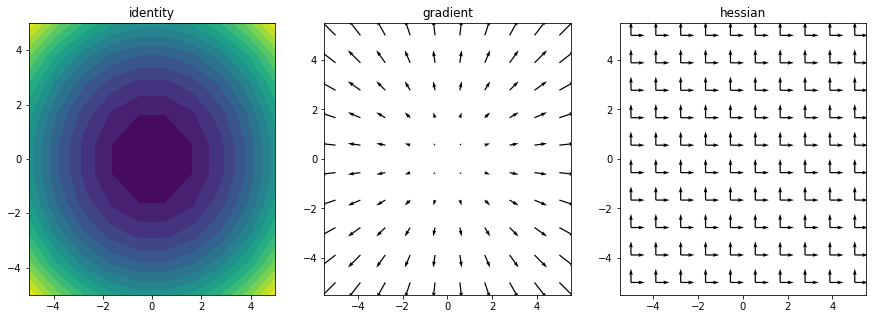

In [4]:
plot_operators(lambda x: 0.5 * jnp.sum(x**2), OPERATORS)

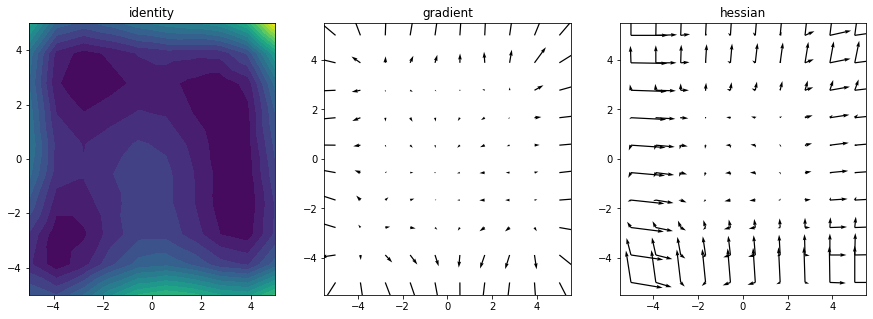

In [5]:
def himmelblau(x):
    return (x[0]**2 + x[1] - 11)**2 + (x[0] + x[1]**2 - 7)**2

plot_operators(himmelblau, OPERATORS)

# Regression under linear operators

In [6]:
operators = OPERATORS
k = rbf
solve = build_solve(k, operators) # Per default, a matrix-free conjuage gradient solver is used.
predict = build_predict(k, operators, operators)

In [7]:
x, observations = make_data(himmelblau, n_samples=50, operators=operators)

def regression(solve):
    alphas = solve(x, observations) # high compile time
    preds = predict(x, x, alphas)
    mse = lambda a, b: jnp.mean((a - b)**2)
    print(jax.tree_map(mse, observations, preds))
    f = build_predict_scalar(k, operators, x, alphas)
    return f

{'gradient': DeviceArray(0.11634648, dtype=float64), 'hessian': DeviceArray(0.25658518, dtype=float64), 'identity': DeviceArray(0.12058612, dtype=float64)}


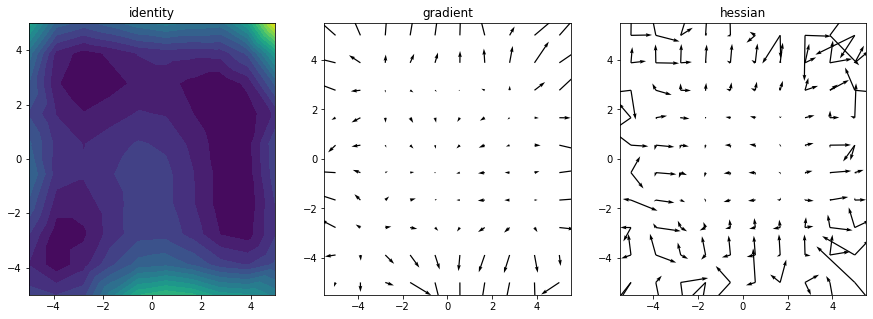

In [8]:
f = regression(solve)
plot_operators(f, operators)

{'gradient': DeviceArray(1.55406944e-08, dtype=float64), 'hessian': DeviceArray(1.75448593e-10, dtype=float64), 'identity': DeviceArray(7.71785241e-08, dtype=float64)}


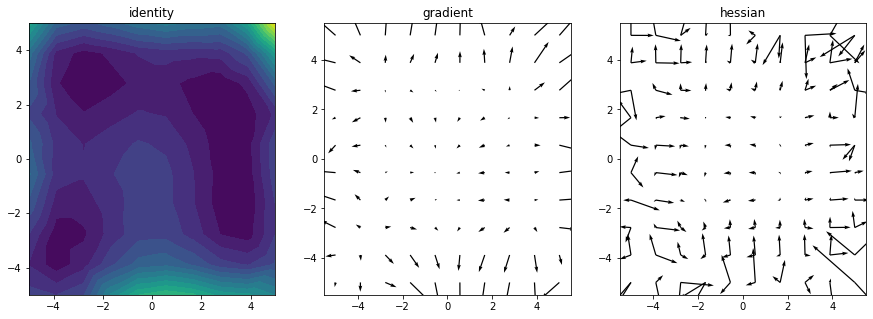

In [9]:
# Alternatively, one can also opt for a cholesky-based approach,
# that computes a full kernelmatrix explicitly. (memory intensive)
solve_cholesky = build_solve(k, operators, solver="cholesky")
f2 = regression(solve_cholesky)
plot_operators(f2, operators)

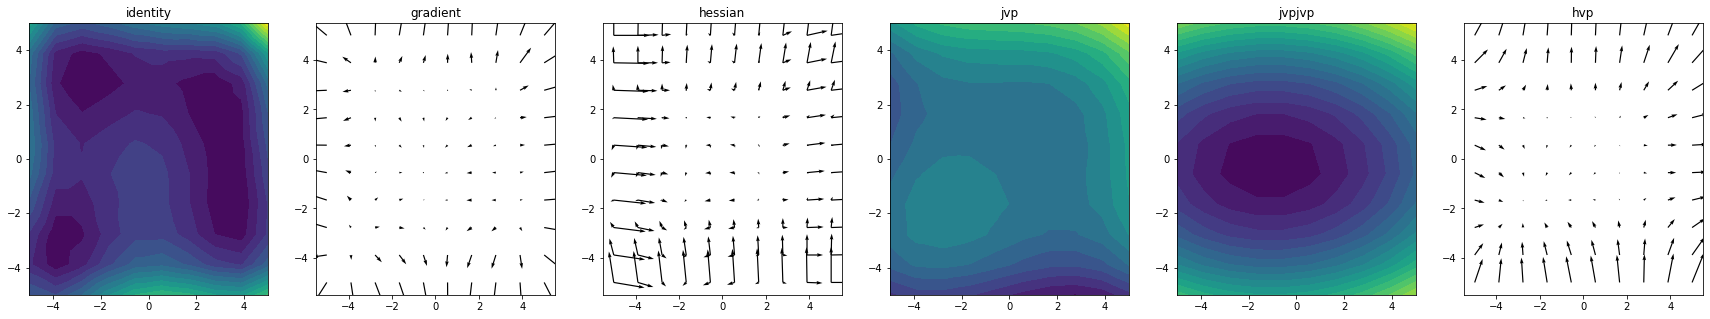

In [12]:
plot_operators(himmelblau, operators)